In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
import json
from helpers import style
from helpers.afa import adaptive_filter
from tqdm import tqdm
from collections import Counter
import networkx as nx

from helpers.linkage import mutual_information_smooth
from helpers.pathtools import *
from helpers.metrics import *
from helpers.visuals import add_cabinet_periods

lda_path = '/home/rb/Documents/Data/models/lda/postwar-v3/'

style.load_style()

from helpers.dataloader import load

Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'infomap', 'graph_tool', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [2]:
dists, dat, _, keys = load(zscore_filter=False)

In [3]:
networks = {}
size_dicts = {}

for cd,(date, _) in enumerate(dists.groupby(dists.index)):
    rij, ri, m = mutual_information_smooth(theta = _.to_numpy())
    rij = pd.DataFrame(rij, index=[keys[int(i)] for i in _.columns], columns=[keys[int(i)] for i in _.columns])
    rij = rij.stack().reset_index().rename(columns={"level_0":"s","level_1":"t",0:"pmi"})
    rij = rij[(rij.s != rij.t) & (rij.pmi > 0)]

    sizes = _.mean()
    sizes.index = sizes.index.astype(int).map(keys)
    sizes = sizes.to_dict()
    g = nx.from_pandas_edgelist(df = rij, source='s', target='t', edge_attr=['pmi'])
    networks[date] = g
    size_dicts[cd] = list(sizes.items())

In [4]:
# for _ in np.arange(2.5,4.5,.25):
#     tc, g, sizes, paths, metadata = get_tc(networks, size_dicts, overlap_threshold=.5, louvain_res=_,verbose=False)
#     plot_flows(g, tc, paths, networks, sizes, cmap='hsv',figsize=(100,20),save=f'figs/chains-{_}.pdf')

In [5]:
tc, g, sizes, paths, metadata = get_tc(networks, size_dicts, overlap_threshold=.5, louvain_res=3,verbose=False)

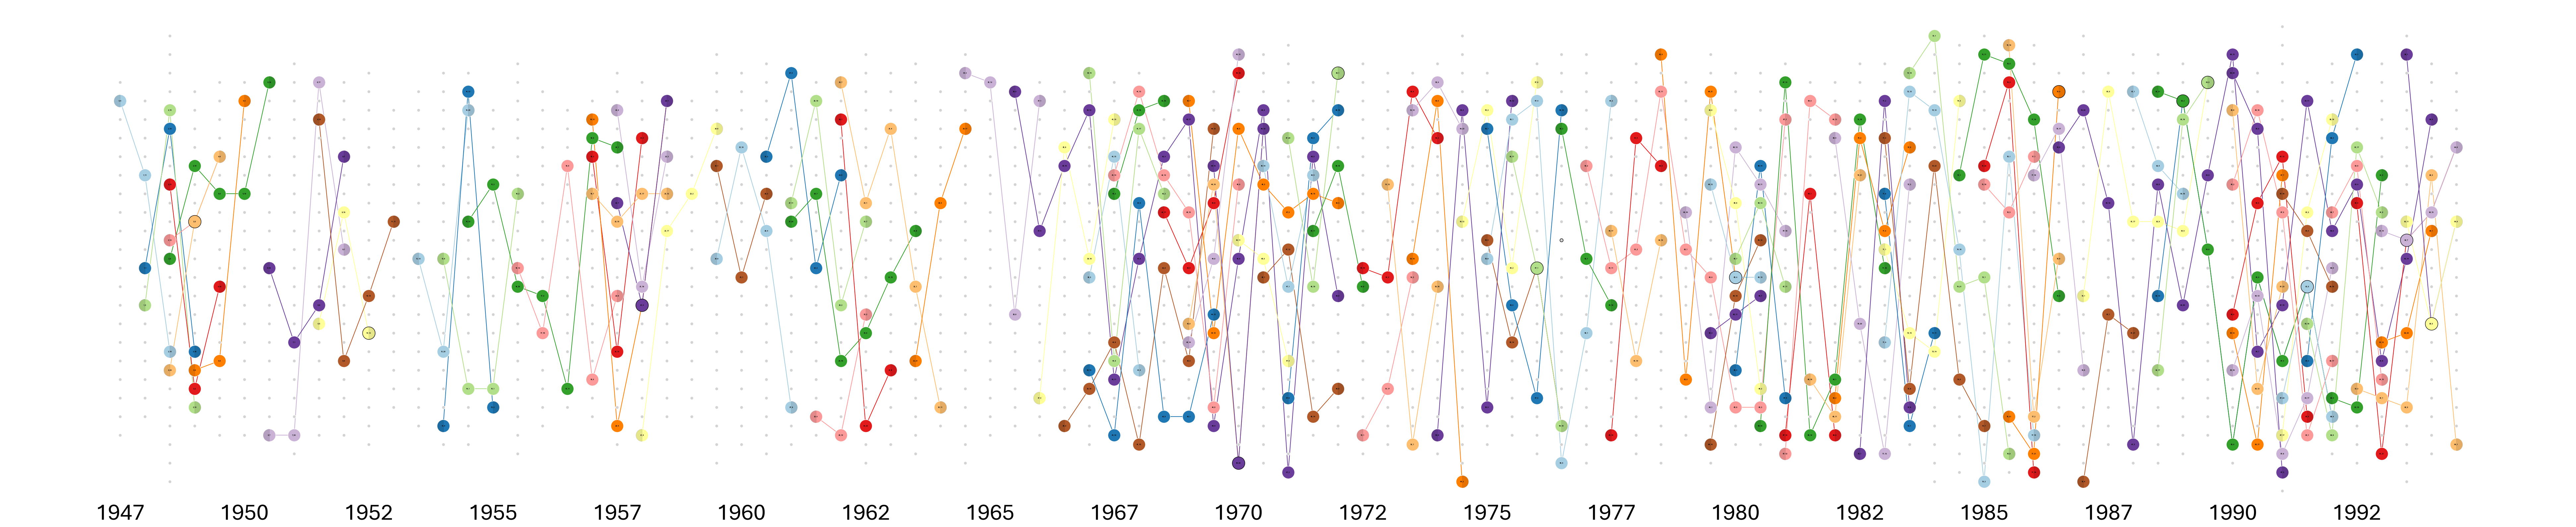

In [6]:
plot_flows(g, tc, paths, networks, sizes, annotate_max_topic=False, cmap='Paired',figsize=(100,20),save=f'figs/chains.png')

## Chain Stats

In [7]:
path_topics = {i:pd.DataFrame([item for items in p for item in tc.get_community(items)],columns=['topic']).value_counts() for i,p in enumerate(paths)}
pdf = pd.DataFrame({i:p.max() for i,p in path_topics.items()}.items(),columns=['path_id','max']).sort_values('max',ascending=False)
pdf['topics'] = pdf.path_id.apply(lambda i:', '.join(path_topics[i].reset_index().topic[:4]))
pdf['len'] = pdf.path_id.apply(lambda i: len(paths[i]))
pdf['max_topic_persistence'] = pdf['max'] / pdf['len']
pdf['mean_topic_persistence'] = pdf.path_id.apply(lambda i:np.mean(path_topics[i] / pdf['len'][i]))

In [12]:
tps = [[item for items in p for item in tc.get_community(items)] for p in paths]
tps = [item for items in tps for item in items]

<Axes: xlabel='period'>

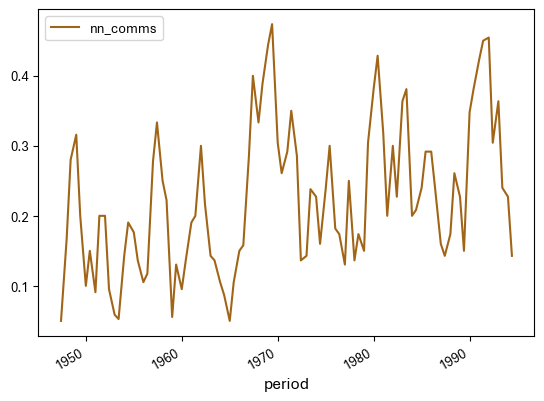

In [15]:
## Coverage (share of communities in paths, not in paper yet)
coverage(tc,paths,networks).plot(x='period',y='nn_comms')